# Tutorial 1: **Notebook** - *FVF*

**By 
gLayout Team**

__Content creators:__ Subham Pal, Saptarshi Ghosh

__Content reviewers:__ Mehedi Saligne

___
# Tutorial Objectives

This notebook is a tutorial on-

- **Importing** and **Placement** of FETs and other macros/Pcells with relative coordinates + Placing (and connecting) Via_stack on the ports of the FETs + encircling them with padrings.
- **Routing** between the placed *Vias* with *C_*, *L_*, *Straight_* and *smart* Routes and explaining the differences between these strategies. Particularly explaning the East/West/North/South angles, (For Example, why C has to parallel but L has to be perpendicular sides) and *Placing and connecting PINs for future LVS runs

## **Target** **Block** : **Flipped Voltage Follwer Cell**

The Flipped Voltage Follower (FVF) is a widely used analog building block known for its low output impedance, fast transient response, and ability to deliver large output current while maintaining voltage buffering properties. It is commonly employed in analog circuit design, particularly in output stages, gain boosting, common-mode feedback circuits, and super class-AB OTAs. 

(a) Conventional Voltage follower (common Drain); (b) Flipped voltage follower (FVF).

![](_images/FVF.png)

```bibtex
Domala, N., Sasikala, G. Low power flipped voltage follower current mirror with improved input output impedances. Sādhanā 46, 142 (2021). https://doi.org/10.1007/s12046-021-01665-6
```

## **Layout generation**
let's go through the step by step procedure to generate LVS and DRC clean layout of a FVF cell.


### *Creating environment for live GDSII viewer*
You can see the generated GDSII file immediately inside this notebook. You can also view it in Klayout for better understanding. Code for viewing it in Klayout is added but commented out.

In [91]:
## Activate if necessary to install following packages

# !pip install svgutils
# !pip install ipywidgets

This cell only required for [IIC-OSIC Docker](https://github.com/iic-jku/IIC-OSIC-TOOLS). It imports all neceaasry environment varriable to current session

In [92]:
import os
import subprocess

# Run a shell, source .bashrc, then printenv
cmd = 'bash -c "source ~/.bashrc && printenv"'
result = subprocess.run(cmd, shell=True, text=True, capture_output=True)
env_vars = {}
for line in result.stdout.splitlines():
    if '=' in line:
        key, value = line.split('=', 1)
        env_vars[key] = value

# Now, update os.environ with these
os.environ.update(env_vars)

In [93]:
import gdstk
import svgutils.transform as sg
import IPython.display
from IPython.display import clear_output
import ipywidgets as widgets

# Redirect all outputs here
hide = widgets.Output()

def display_gds(gds_file, path,scale = 3):
  
  # Generate an SVG image
  top_level_cell = gdstk.read_gds(gds_file).top_level()[0]
  top_level_cell.write_svg(os.path.join(path,'out.svg'))
    
  # Scale the image for displaying
  fig = sg.fromfile(os.path.join(path,'out.svg'))
  fig.set_size((str(float(fig.width) * scale), str(float(fig.height) * scale)))
  fig.save(os.path.join(path,'out.svg'))

  # Display the image
  IPython.display.display(IPython.display.SVG(os.path.join(path,'out.svg')))
  os.remove(os.path.join(path,'out.gds'))

def display_component(component,path,scale = 3):
  # Save to a GDS file
  with hide:
    component.write_gds(os.path.join(path,'out.gds'))
  display_gds(os.path.join(path,'out.gds'),path,scale)

In [94]:
from glayout import MappedPDK, sky130 , gf180
#from gdsfactory.cell import cell
from gdsfactory import Component
from gdsfactory.components import text_freetype, rectangle

In [95]:
from glayout import nmos, pmos
from glayout import via_stack
from glayout import rename_ports_by_orientation
from glayout import tapring

In [96]:
from glayout.util.comp_utils import evaluate_bbox, prec_center, prec_ref_center, align_comp_to_port
from glayout.util.port_utils import add_ports_perimeter,print_ports
from glayout.util.snap_to_grid import component_snap_to_grid
from glayout.spice.netlist import Netlist

In [97]:
from glayout.routing.straight_route import straight_route
from glayout.routing.c_route import c_route
from glayout.routing.L_route import L_route

FVF has two fets as shown in the schematic. We call M1 as input fet and M2 as feedback fet. Lets define arguments for the FETs

In [98]:
nmos_kwargs = {
    "with_tie": True,
    "with_dnwell": True,
    "sd_route_topmet": "met2",
    "gate_route_topmet": "met2",
    "sd_route_left": True,
    "rmult": None,
    "gate_rmult": 1,
    "interfinger_rmult": 1,
    "substrate_tap_layers": ("met2","met1"),
    "dummy_routes": True
}

pmos_kwargs = {
    "with_tie": True,
    "dnwell": False,
    "sd_route_topmet": "met2",
    "gate_route_topmet": "met2",
    "sd_route_left": True,
    "rmult": None,
    "gate_rmult": 1,
    "interfinger_rmult": 1,
    "substrate_tap_layers": ("met2","met1"),
    "dummy_routes": True
}

There is no need to manually define the kwargs for your code. This is only done for this notebook implementation.


Now, Let's create a list for parameters which we need for our function-

* pdk: pdk to use
* device_type: either "nmos" or "pmos"
* placement: either "horizontal" or "vertical"
* width: (input fet, feedback fet)
* length: (input fet, feedback fet)
* fingers: (input fet, feedback fet)
* multipliers: (input fet, feedback fet)
* dummy_1: dummy for input fet
* dummy_2: dummy for feedback fet
* tie_layers1: tie layers for input fet
* tie_layers2: tie layers for feedback fet
* sd_rmult: sd_rmult for both fets


In [99]:
flipped_voltage_follower_config={
        "pdk": gf180, # pdk to use
        "device_type": "nmos", # either nmos or pmos
        "placement" : "horizontal", # the two fets can be placed either vertically or horizontally
        "width": (3,3), # width of the input fet and feedback fet respectively.
        "length": (None,None), # length of the input fet and feedback fet respectively. None refers to the min length in the pdk.
        "fingers": (1,1), # no. of fingers of the input fet and feedback fet respectively.
        "multipliers": (1,1), #no. of multipliers of the input fet and feedback fet respectively.
        "dummy_1": (True,True), # dummy pattern for input fet (left,right)
        "dummy_2": (True,True), # dummy pattern for the feedback fet (left,right)
        "tie_layers1": ("met2","met1"), #tapring metal layers for input fet
        "tie_layers2": ("met2","met1"), #tapring metal layers for feedback fet
        "sd_rmult":1, # thickness of the sd metal layer.
}

### First: We create a top level component and add a name

In [100]:
top_level = Component(name="flipped_voltage_follower")

### Two fets

For our fvf block, we do not want deep nwell. However nmos and pmos primitives have different parameter name for deepnwell.
For pmos it is set to false by default.We need to set it to false if the device type is given as nmos.
We could've just set it properly in our nmos_kwargs,
but since you will probably not code the layout for a notebook, we show a general way of solving this issue.


In [101]:
device_type = flipped_voltage_follower_config["device_type"]
device_map = {
        "nmos": nmos,
        "pmos":pmos,
        }

device = device_map.get(device_type)
if device_type == "nmos":
      nmos_kwargs["with_dnwell"] = False

In [102]:
pdk=flipped_voltage_follower_config["pdk"]
pdk.activate()

In [103]:
width=flipped_voltage_follower_config["width"]
length=flipped_voltage_follower_config["length"]
fingers=flipped_voltage_follower_config["fingers"]
multipliers=flipped_voltage_follower_config["multipliers"]

dummy_1=flipped_voltage_follower_config["dummy_1"]
dummy_2=flipped_voltage_follower_config["dummy_2"]
tie_layers1=flipped_voltage_follower_config["tie_layers1"]
tie_layers2=flipped_voltage_follower_config["tie_layers2"]
sd_rmult=flipped_voltage_follower_config["sd_rmult"]

In [104]:
#fet_1 is the input fet
fet_1 = device(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **(nmos_kwargs if device_type == "nmos" else pmos_kwargs))
#fet_2 is the feedback fet
fet_2 = device(pdk, width=width[1], fingers=fingers[1], multipliers=multipliers[1], with_dummy=dummy_2, with_substrate_tap=False, length=length[1], tie_layers=tie_layers2, sd_rmult=sd_rmult, **(nmos_kwargs if device_type == "nmos" else pmos_kwargs))
well = "pwell" if device == nmos else "nwell"

Adding the references of the FETs to the top level component

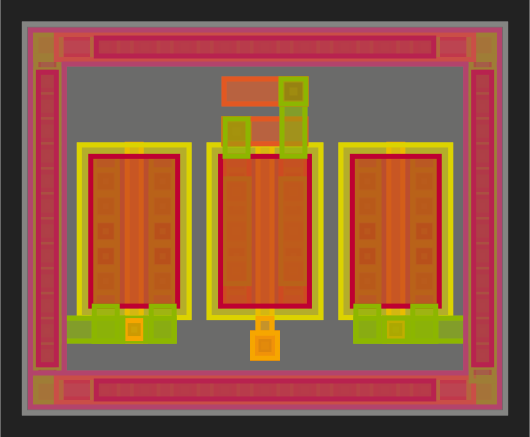

In [105]:
fet_1_ref = top_level << fet_1
fet_2_ref = top_level << fet_2

fet_1_ref.name = "fet1_ref"
fet_2_ref.name = "fet2_ref"

#let's take a look at our current state of layout
## To see in Klayout via Klive
#top_level.show()
display_component(top_level, scale = 5,path="../../")
## If you want to save the gds file at this stage
#primary_gds = top_level.write_gds("before_placement.gds")

### Placement

When a cell is referenced to the top level, the center of the cell is aligned to the (0,0) co-ordinate.
As of now, both of our fets are centered at (0,0). We need place them properly depending on the placement parameter.

In [106]:
placement=flipped_voltage_follower_config["placement"]
ref_dimensions = evaluate_bbox(fet_2)


evaluate_bbox returns maximum width and maximum height of the block as a tuple(width,height).

So here we have `ref_dimensions=(x-dimension of fet_2, y-dimension of fet_2)`

For horizontal placement , we need to move the fet_2 in rightward direction.
We use the movex function, which moves the center of the block in x-directon upto a certain distance. We need to find out this distance.
Remember that both fet_1 and fet_2 are centered at (0,0) co-ordinate right now.
At first we move the center of fet_2 to rightmost point of fet_1 using the xmax function, i.e, (fet_1_ref.xmax,0).
Now we will find that left half of fet_2 is overlapping with fet_1, so we need to move it at rightward direction again.We move it by ref_dimensionsp[0]/2 distance.
Now we see that the rightmost point of fet_1 and leftmost point of fet_2 have no seperation between them.
This will cause a drc error. So we move it again by max seperation needed between two metal layers for drc free layout.
We move it by 1um again for leaving some routing space for future use.

Vertical placement can be done in similar way by using movey function.

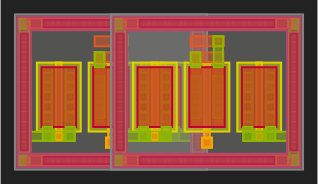

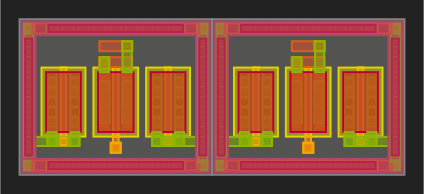

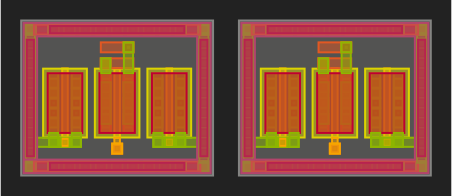

In [107]:
if placement == "horizontal":
    fet_2_ref.movex(fet_1_ref.xmax)
    display_component(top_level, scale = 2,path="../../")
    fet_2_ref.movex(ref_dimensions[0]/2)
    display_component(top_level, scale = 2,path="../../")
    fet_2_ref.movex(pdk.util_max_metal_seperation()+1)
if placement == "vertical":
    display_component(top_level, scale = 2,path="../../")
    fet_2_ref.movey(fet_1_ref.ymin - ref_dimensions[1]/2 - pdk.util_max_metal_seperation()-1)

# let's see how our block looks after placement
display_component(top_level, scale = 2,path="../../")
## To see in Klayout via Klive
#top_level.show()

 ### Routing

Now that our fets are properly placed, we need to make proper connections between ports (i.e. Gates, Sources and Drains of the FETs).
Each port has four directions- East,North,West,South which means 0,90,180,270 degrees respectively.
You can connect directly to a fet port. For better felxibility in routing, we choose add some intermediate vias here.

![](_images/port_route.png)


In [108]:
viam2m3 = via_stack(pdk, "met2", "met3", centered=True) #met2 is the bottom layer. met3 is the top layer.

#we need four such vias
drain_1_via = top_level << viam2m3
source_1_via = top_level << viam2m3
gate_1_via = top_level << viam2m3

drain_2_via = top_level << viam2m3
gate_2_via = top_level << viam2m3

The move function moves the center of a specific cell to a specific co-ordinate.
The co-ordinates of the center of a port can be accesed by using cell_name.ports["port_name"].center
Using these two and other techniques previously discussed, we properly place these 4 vias.

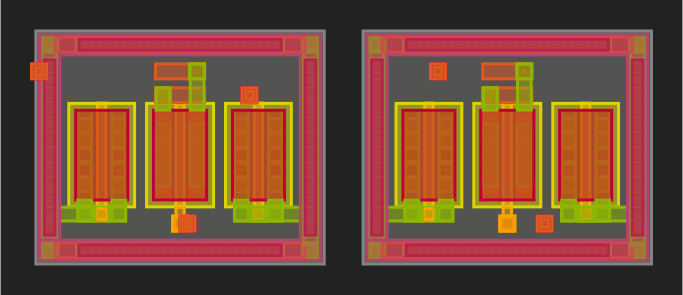

In [109]:
drain_1_via.move(fet_1_ref.ports["multiplier_0_drain_W"].center).movex(-0.5*evaluate_bbox(fet_1)[1])
source_1_via.move(fet_1_ref.ports["multiplier_0_source_E"].center).movex(1.5)
gate_1_via.move(fet_1_ref.ports["multiplier_0_gate_E"].center)

drain_2_via.move(fet_2_ref.ports["multiplier_0_drain_W"].center).movex(-1.5)
gate_2_via.move(fet_2_ref.ports["multiplier_0_gate_E"].center).movex(1)

# let's see where those vias are now
## To see in Klayout via Klive
#top_level.show()
display_component(top_level, scale = 3,path="../../")

Now that the vias are placed, time to make metal routing.
There are three basic types of routing available:

- `straight_route` - the ports must be straight to each other, i.e, opposite direction and same x or y coordinate.
- `L_route` - has a 90&deg; bend, ports must be perpendicular to each other.
- `c_route` -  has two 90&deg; bends(c shaped), ports must have same direction.

Each routing function has multiple parameters. See [here](https://github.com/idea-fasoc/OpenFASOC/tree/main/openfasoc/generators/glayout/glayout/flow/routing)

![](_images/route_direction.png)

Bonus: You can see all avaliable ports by `top_level.pprint_ports()`

From the schematic, we see that we need to connect these two nodes-

1. Source of M1 and Drain of M2, we insert two intermediate vias near each of them and connect them.
2. Gate of M2 and Drain of M1, we insert two intermediate vias near each of them and connect them.

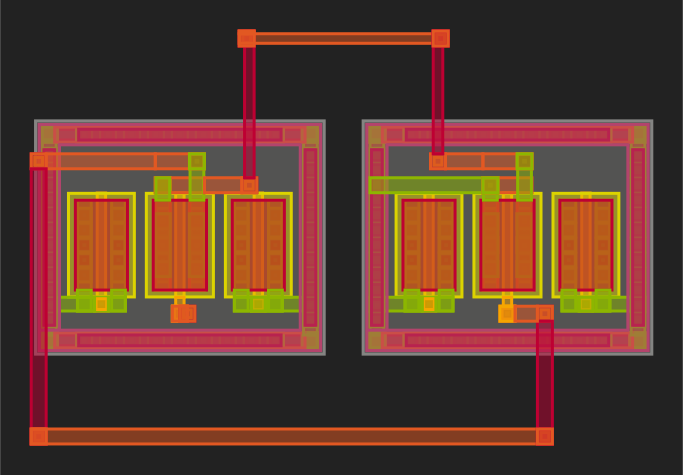

In [110]:
top_level << straight_route(pdk, fet_1_ref.ports["multiplier_0_source_E"], source_1_via.ports["bottom_met_W"])
top_level << straight_route(pdk, fet_1_ref.ports["multiplier_0_gate_S"], gate_1_via.ports["bottom_met_N"])
top_level << straight_route(pdk, fet_2_ref.ports["multiplier_0_drain_W"], drain_2_via.ports["bottom_met_E"])
top_level << c_route(pdk, source_1_via.ports["top_met_N"], drain_2_via.ports["top_met_N"], extension=1.2*max(width[0],width[1]), width1=0.32, width2=0.32, cwidth=0.32, e1glayer="met3", e2glayer="met3", cglayer="met2")
top_level << straight_route(pdk, fet_1_ref.ports["multiplier_0_drain_W"], drain_1_via.ports["bottom_met_E"])
top_level << c_route(pdk, drain_1_via.ports["top_met_S"], gate_2_via.ports["top_met_S"], extension=1.2*max(width[0],width[1]), cglayer="met2")
top_level << straight_route(pdk, fet_2_ref.ports["multiplier_0_gate_E"], gate_2_via.ports["bottom_met_W"])
try:
    top_level << straight_route(pdk, fet_2_ref.ports["multiplier_0_source_W"], fet_2_ref.ports["tie_W_top_met_W"], glayer1=tie_layers2[1], fullbottom=True)
except:
    pass

# let's see how those vias are now routed
#top_level.show()
display_component(top_level, scale = 3,path="../../")

Notice how in the above lines, ports used in straight routing has the opposite direction, e.g. (E,W) but ports used in c_route has the same direction (N,N).

### Renaming Ports

We need to rename ports and add them to the top level component for ease of routing in hierarchial design.
Here we rename ports by adding appropriate prefix to the all ready existing port names.


In [111]:
top_level.add_ports(fet_1_ref.get_ports_list(), prefix="A_")
top_level.add_ports(fet_2_ref.get_ports_list(), prefix="B_")
top_level.add_ports(drain_1_via.get_ports_list(), prefix="A_drain_")
top_level.add_ports(source_1_via.get_ports_list(), prefix="A_source_")
top_level.add_ports(gate_1_via.get_ports_list(), prefix="A_gate_")
top_level.add_ports(drain_2_via.get_ports_list(), prefix="B_drain_")
top_level.add_ports(gate_2_via.get_ports_list(), prefix="B_gate_")

### Add nwell

for pmos device type, we need to add nwell.
However we do not need to add pwell for nmos device type as magic does not seperately extract the pwell layer.


In [112]:
if well == "nwell":
    top_level.add_padding(layers=(pdk.get_glayer("nwell"),),default= 1 )

## Add tapring

In [113]:
shift_amount = -prec_center(top_level.flatten())[0];
tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(top_level.flatten(), padding=pdk.get_grule("nwell")['min_separation']));
tring_ref = top_level << tap_ring;
tring_ref.movex(destination=shift_amount);

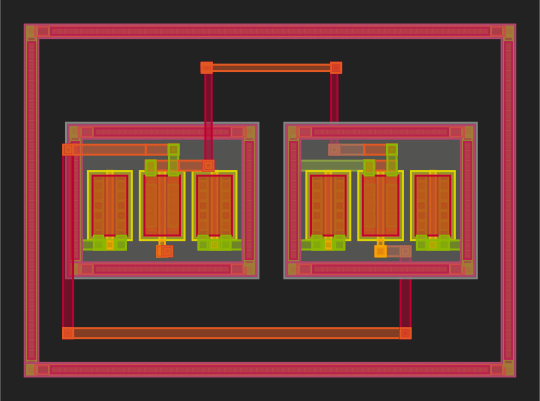

In [114]:
component = component_snap_to_grid(rename_ports_by_orientation(top_level))

# Now that our block is complete, let's see how it looks now!!
#component.show()
display_component(component, scale = 2,path="../../")
#component.show()
##fvf_gds = component.write_gds("fvf.gds")

Printing List of Ports of the Component

In [115]:
## To see all Ports
# component.pprint_ports()

## To see selected ports
# for s in component.get_ports_list():
#     if len(s.name.split("_")) <4:
#         if set(["A","gate"]).issubset(set(s.name.split("_"))):
#             print(s.name, s.port_type , s.orientation, s.center, s.width, s.layer)

### Add Pins
We need to add i/o pins, power supply pins and bias pins to a circuit. This will be needed later to do LVS check(Layout Vs Schematic) and parasitic extraction(PEX).
Our flipped voltage follwer has four pins- VIN, VOUT, Ib, VBULK

In [116]:
psize=(0.5,0.5)
# list that will contain all port/comp info
move_info = list()
# create labels and append to info list

/headless/conda-env/miniconda3/envs/GLdev/lib/python3.10/site-packages/gdsfactory/show.py:40: UserWarning: Unnamed cells, 1 in 'Unnamed_00e228e1'
  gdspath = component.write_gds(
2025-06-26 07:18:38.751 | INFO     | gdsfactory.klive:show:55 - Message from klive: {"version": "0.3.3", "klayout_version": "0.30.2", "type": "open", "file": "/tmp/gdsfactory/Unnamed_00e228e1.gds"}


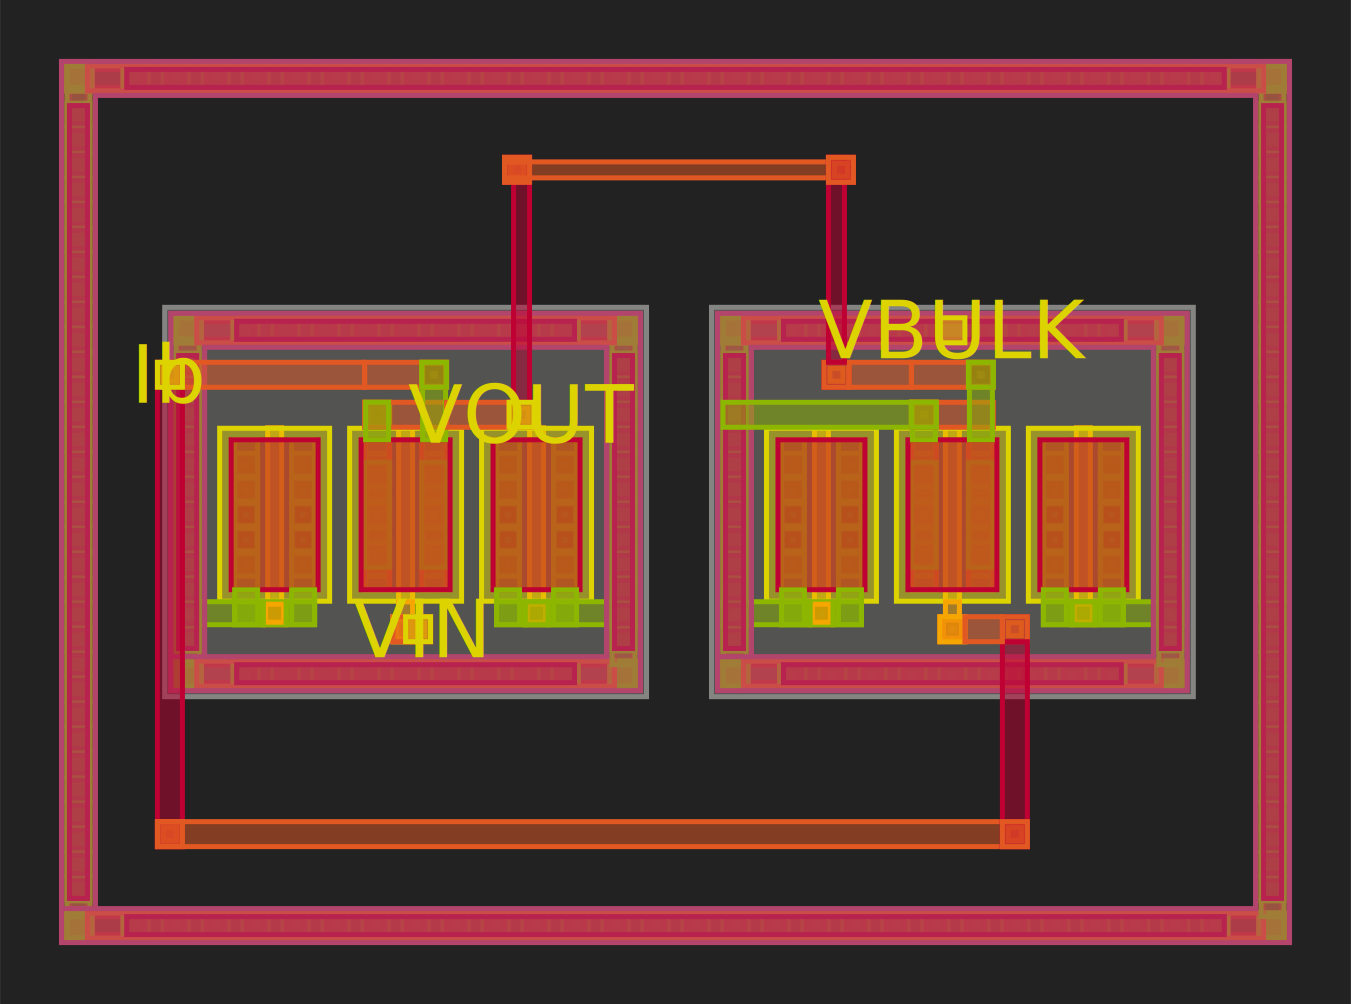

In [117]:
# gnd
gndlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
gndlabel.add_label(text="VBULK",layer=pdk.get_glayer("met3_label"))
move_info.append((gndlabel,component.ports["B_tie_N_top_met_N"],None))
#gnd_ref = top_level << gndlabel;



#currentbias
ibiaslabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
ibiaslabel.add_label(text="Ib",layer=pdk.get_glayer("met3_pin"))
move_info.append((ibiaslabel,component.ports["A_drain_top_met_N"],None))
#ib_ref = top_level << ibiaslabel;


# output
outputlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
outputlabel.add_label(text="VOUT",layer=pdk.get_glayer("met3_pin"))
move_info.append((outputlabel,component.ports["A_source_top_met_N"],None))
#op_ref = top_level << outputlabel;


# input
inputlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
inputlabel.add_label(text="VIN",layer=pdk.get_glayer("met3_pin"))
move_info.append((inputlabel,component.ports["A_gate_top_met_N"], None))
#ip_ref = top_level << inputlabel;


for comp, prt, alignment in move_info:
        alignment = ('c','b') if alignment is None else alignment
        compref = align_comp_to_port(comp, prt, alignment=alignment)
        top_level.add(compref)
component = top_level.flatten()


component.show()
display_component(top_level, scale =5,path="../../")

## Note
Now, lets construct the Pcell and export this code as a `.py` file. This is how your cell contributions should be structured. 

In [118]:
fvf_code_string = """
from glayout import MappedPDK, sky130 , gf180
from gdsfactory.cell import cell
from gdsfactory import Component
from gdsfactory.components import text_freetype, rectangle

from glayout import nmos, pmos
from glayout import via_stack
from glayout import rename_ports_by_orientation
from glayout import tapring

from glayout.util.comp_utils import evaluate_bbox, prec_center, prec_ref_center, align_comp_to_port
from glayout.util.port_utils import add_ports_perimeter,print_ports
from glayout.util.snap_to_grid import component_snap_to_grid
from glayout.spice.netlist import Netlist

from glayout.routing.straight_route import straight_route
from glayout.routing.c_route import c_route
from glayout.routing.L_route import L_route


###### Only Required for IIC-OSIC Docker
import os
import subprocess

# Run a shell, source .bashrc, then printenv
cmd = 'bash -c "source ~/.bashrc && printenv"'
result = subprocess.run(cmd, shell=True, text=True, capture_output=True)
env_vars = {}
for line in result.stdout.splitlines():
    if '=' in line:
        key, value = line.split('=', 1)
        env_vars[key] = value

# Now, update os.environ with these
os.environ.update(env_vars)


def add_fvf_labels(
    fvf_in: Component,
    pdk: MappedPDK,
    ) -> Component:
    fvf_in.unlock()

    psize=(0.5,0.5)
    # list that will contain all port/comp info
    move_info = list()
    # create labels and append to info list

    # gnd
    gndlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    gndlabel.add_label(text="VBULK",layer=pdk.get_glayer("met3_label"))
    move_info.append((gndlabel,fvf_in.ports["B_tie_N_top_met_N"],None))
    #gnd_ref = top_level << gndlabel;
    
    
    
    #currentbias
    ibiaslabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    ibiaslabel.add_label(text="Ib",layer=pdk.get_glayer("met3_pin"))
    move_info.append((ibiaslabel,fvf_in.ports["A_drain_top_met_N"],None))
    #ib_ref = top_level << ibiaslabel;
    
    
    # output
    outputlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    outputlabel.add_label(text="VOUT",layer=pdk.get_glayer("met3_pin"))
    move_info.append((outputlabel,fvf_in.ports["A_source_top_met_N"],None))
    #op_ref = top_level << outputlabel;
    
    
    # input
    inputlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    inputlabel.add_label(text="VIN",layer=pdk.get_glayer("met3_pin"))
    move_info.append((inputlabel,fvf_in.ports["A_gate_top_met_N"], None))
    #ip_ref = top_level << inputlabel;
    
    
    # move everything to position
    for comp, prt, alignment in move_info:
        alignment = ('c','b') if alignment is None else alignment
        compref = align_comp_to_port(comp, prt, alignment=alignment)
        fvf_in.add(compref)
        
    return fvf_in.flatten() 

@cell
def  flipped_voltage_follower(
        pdk: MappedPDK,
        device_type: str = "nmos", 
        placement: str = "horizontal",
        width: tuple[float,float] = (3,3),
        length: tuple[float,float] = (None,None),
        fingers: tuple[int,int] = (1,1),
        multipliers: tuple[int,int] = (1,1),
        dummy_1: tuple[bool,bool] = (True,True),
        dummy_2: tuple[bool,bool] = (True,True),
        tie_layers1: tuple[str,str] = ("met2","met1"),
        tie_layers2: tuple[str,str] = ("met2","met1"),
        sd_rmult: int=1,
        **kwargs
        ) -> Component:

    pdk.activate()
    
    #top level component
    top_level = Component(name="flipped_voltage_follower")

    #two fets
    device_map = {
            "nmos": nmos,
            "pmos":pmos,
            }
    device = device_map.get(device_type)
    if device_type == "nmos":
    	kwargs["with_dnwell"] = False  

    fet_1 = device(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **kwargs)
    fet_2 = device(pdk, width=width[1], fingers=fingers[1], multipliers=multipliers[1], with_dummy=dummy_2, with_substrate_tap=False, length=length[1], tie_layers=tie_layers2, sd_rmult=sd_rmult, **kwargs)
    well = "pwell" if device == nmos else "nwell" 

    fet_1_ref = top_level << fet_1
    fet_2_ref = top_level << fet_2 
    fet_1_ref.name = "fet1_ref"
    fet_2_ref.name = "fet2_ref"

    #Relative move
    ref_dimensions = evaluate_bbox(fet_2)
    if placement == "horizontal":
        fet_2_ref.movex(fet_1_ref.xmax + ref_dimensions[0]/2 + pdk.util_max_metal_seperation()+1)
    if placement == "vertical":
        fet_2_ref.movey(fet_1_ref.ymin - ref_dimensions[1]/2 - pdk.util_max_metal_seperation()-1)
    
    #Routing
    viam2m3 = via_stack(pdk, "met2", "met3", centered=True)
    drain_1_via = top_level << viam2m3
    source_1_via = top_level << viam2m3
    gate_1_via = top_level << viam2m3

    drain_2_via = top_level << viam2m3
    gate_2_via = top_level << viam2m3
    
    drain_1_via.move(fet_1_ref.ports["multiplier_0_drain_W"].center).movex(-0.5*evaluate_bbox(fet_1)[1])
    source_1_via.move(fet_1_ref.ports["multiplier_0_source_E"].center).movex(1.5)
    gate_1_via.move(fet_1_ref.ports["multiplier_0_gate_E"].center)

    drain_2_via.move(fet_2_ref.ports["multiplier_0_drain_W"].center).movex(-1.5)
    gate_2_via.move(fet_2_ref.ports["multiplier_0_gate_E"].center).movex(1)

    top_level << straight_route(pdk, fet_1_ref.ports["multiplier_0_source_E"], source_1_via.ports["bottom_met_W"])
    top_level << straight_route(pdk, fet_1_ref.ports["multiplier_0_gate_S"], gate_1_via.ports["bottom_met_N"])
    top_level << straight_route(pdk, fet_2_ref.ports["multiplier_0_drain_W"], drain_2_via.ports["bottom_met_E"])
    top_level << c_route(pdk, source_1_via.ports["top_met_N"], drain_2_via.ports["top_met_N"], extension=1.2*max(width[0],width[1]), width1=0.32, width2=0.32, cwidth=0.32, e1glayer="met3", e2glayer="met3", cglayer="met2")
    top_level << straight_route(pdk, fet_1_ref.ports["multiplier_0_drain_W"], drain_1_via.ports["bottom_met_E"])
    top_level << c_route(pdk, drain_1_via.ports["top_met_S"], gate_2_via.ports["top_met_S"], extension=1.2*max(width[0],width[1]), cglayer="met2")
    top_level << straight_route(pdk, fet_2_ref.ports["multiplier_0_gate_E"], gate_2_via.ports["bottom_met_W"])
    try:
	    top_level << straight_route(pdk, fet_2_ref.ports["multiplier_0_source_W"], fet_2_ref.ports["tie_W_top_met_W"], glayer1=tie_layers2[1], fullbottom=True)
    except:
	    pass
    #Renaming Ports
    top_level.add_ports(fet_1_ref.get_ports_list(), prefix="A_")
    top_level.add_ports(fet_2_ref.get_ports_list(), prefix="B_")
    top_level.add_ports(drain_1_via.get_ports_list(), prefix="A_drain_")
    top_level.add_ports(source_1_via.get_ports_list(), prefix="A_source_")
    top_level.add_ports(gate_1_via.get_ports_list(), prefix="A_gate_")
    top_level.add_ports(drain_2_via.get_ports_list(), prefix="B_drain_")
    top_level.add_ports(gate_2_via.get_ports_list(), prefix="B_gate_")
    #add nwell
    if well == "nwell": 
        top_level.add_padding(layers=(pdk.get_glayer("nwell"),),default= 1 )
    #add tapring
    shift_amount = -prec_center(top_level.flatten())[0];
    tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(top_level.flatten(), padding=pdk.get_grule("nwell")['min_separation']));
    tring_ref = top_level << tap_ring;
    tring_ref.movex(destination=shift_amount);
    
    component = component_snap_to_grid(rename_ports_by_orientation(top_level))
    
    return component

if __name__ == "__main__":
\tcomp = flipped_voltage_follower(gf180, device_type='nmos')\n
\t# comp.pprint_ports()\n
\tcomp = add_fvf_labels(comp, gf180)\n
\tcomp.name = "FVF"\n
\tcomp.write_gds('out_FVF.gds')\n
\tcomp.show()\n
\tprint("...Running DRC...")\n
\tdrc_result = gf180.drc_magic(comp, "FVF")\n
\t#drc_result = gf180.drc(comp)\n

"""

fvf_init_string = """
###Glayout FVF Cell.


from .my_FVF import flipped_voltage_follower,add_fvf_labels

__all__ = [
    'flipped_voltage_follower',
    'add_fvf_labels',
] 
"""

directory = "../../FVF/"
os.makedirs(directory, exist_ok=True)

# Save to a .py file
with open(directory + "my_FVF.py", "w") as file:
    file.write(fvf_code_string)

with open(directory + "__init__.py", "w") as file:
    file.write(fvf_init_string)

### Run DRC with Magic
Design Rule Check ensures that the physical layout of an integrated circuit adheres to the manufacturing constraints defined by the foundry, such as minimum spacing, width, and enclosure rules. `Magic` is the tool we use for DRC here.

In [119]:
component.name="fvf"
drc_result = gf180.drc_magic(component, component.name)

2025-06-26 07:18:38.868 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to '/tmp/tmpcvyfz6oi/fvf$3.gds'


using default pdk_root: /usr/bin/miniconda3/share/pdk/
Defaulting to stale magic_commands.tcl

Magic 8.3 revision 528 - Compiled on Wed Jun 18 09:45:25 PM CEST 2025.
Starting magic under Tcl interpreter
Using the terminal as the console.
Using NULL graphics device.
Processing system .magicrc file
Sourcing design .magicrc for technology gf180mcuD ...
10 Magic internal units = 1 Lambda
Input style import: scaleFactor=10, multiplier=2
The following types are not handled by extraction and will be treated as non-electrical types:
    obsactive mvobsactive filldiff fillpoly m1hole obsm1 fillm1 obsv1 m2hole obsm2 fillm2 obsv2 m3hole obsm3 fillm3 m4hole obsm4 fillm4 m5hole obsm5 fillm5 glass fillblock lvstext obscomment 
Scaled tech values by 10 / 1 to match internal grid scaling
Loading gf180mcuD Device Generator Menu ...
Loading "/tmp/tmpcvyfz6oi/magic_commands.tcl" from command line.
Library written using GDS-II Release 6.0
Library name: library
Reading "fvf$3".
[INFO]: Loading fvf$3

Loadi

### DRC Checking Using External Tools (KLayout)
Design Rule Check (DRC) is the process of ensuring that a particular layout does not violate the constraints or _design rules_ imposed by the PDK.

[Klayout](https://klayout.de/) is a GDSII viewer and editor that also has a DRC feature. The design rules for the PDK, in this case the GF180 PDK, are described in a `.lydrc` file.

The following cell runs DRC on the component generated in the previous cell. The number of DRC errors reported will be displayed at the end of the output.

In [120]:
drc_result = gf180.drc(component)

2025-06-26 07:18:39.225 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to '/tmp/tmppeocs7j3/fvf$3.gds'


2025-06-26 07:18:41 +0200: Memory Usage (646632K) : Starting running GF180MCU Klayout DRC runset on /tmp/tmppeocs7j3/fvf$3.gds
2025-06-26 07:18:41 +0200: Memory Usage (646696K) : Loading database to memory is complete.
2025-06-26 07:18:41 +0200: Memory Usage (646696K) : GF180MCU Klayout DRC runset output at: /foss/designs/all_last2/gLayout-IHP130/tutorial/gf180fvf$3_drcreport.lyrdb
2025-06-26 07:18:41 +0200: Memory Usage (646696K) : Number of threads to use 16
2025-06-26 07:18:41 +0200: Memory Usage (646696K) : flat  mode is enabled.
2025-06-26 07:18:41 +0200: Memory Usage (646696K) : Read in polygons from layers.
2025-06-26 07:18:41 +0200: Memory Usage (647784K) : Starting deriving base layers.
2025-06-26 07:18:41 +0200: Memory Usage (648076K) : Evaluate switches.
2025-06-26 07:18:41 +0200: Memory Usage (648076K) : FEOL is enabled.
2025-06-26 07:18:41 +0200: Memory Usage (648076K) : BEOL is enabled.
2025-06-26 07:18:41 +0200: Memory Usage (648076K) : connectivity rules are enabled.
20